# ResNet-LSTM Model Finetuning Experiment Summary

## Experiment 1: Without Delay

### Procedure:
1. Fine-tune ResNet on generated dataset
2. Load ResNet model and freeze ResNet feature extractor
3. Finetune ResNet-LSTM model on task **without** adding a delay

### Results:
- Accuracy dropped on dataset where a delay was added

## Experiment 2: With Delay

### Procedure:
1. Fine-tune ResNet on generated dataset
2. Load ResNet model and freeze ResNet feature extractor
3. Finetune ResNet-LSTM model on task **with** adding a delay

### Results:
- Accuracy remained high on dataset where a delay was added
- High accuracy maintained even with multiple delays (tested up to 15 frames delay)

## Key Findings:
- Adding a delay during the finetuning process significantly improved the model's robustness to delays in the input data
- The model trained with delay maintained high accuracy even with varying amounts of delay (up to 15 frames)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
parent = os.path.dirname(os.getcwd())
parent = os.path.dirname(parent)

print(f"{parent = }")


import sys
if not parent in sys.path:
    sys.path.append(parent)

parent = '/lustre06/project/6067616/soroush1/WM_age_of_ultron'


In [3]:
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
import matplotlib.pyplot as plt

import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

Files already downloaded and verified


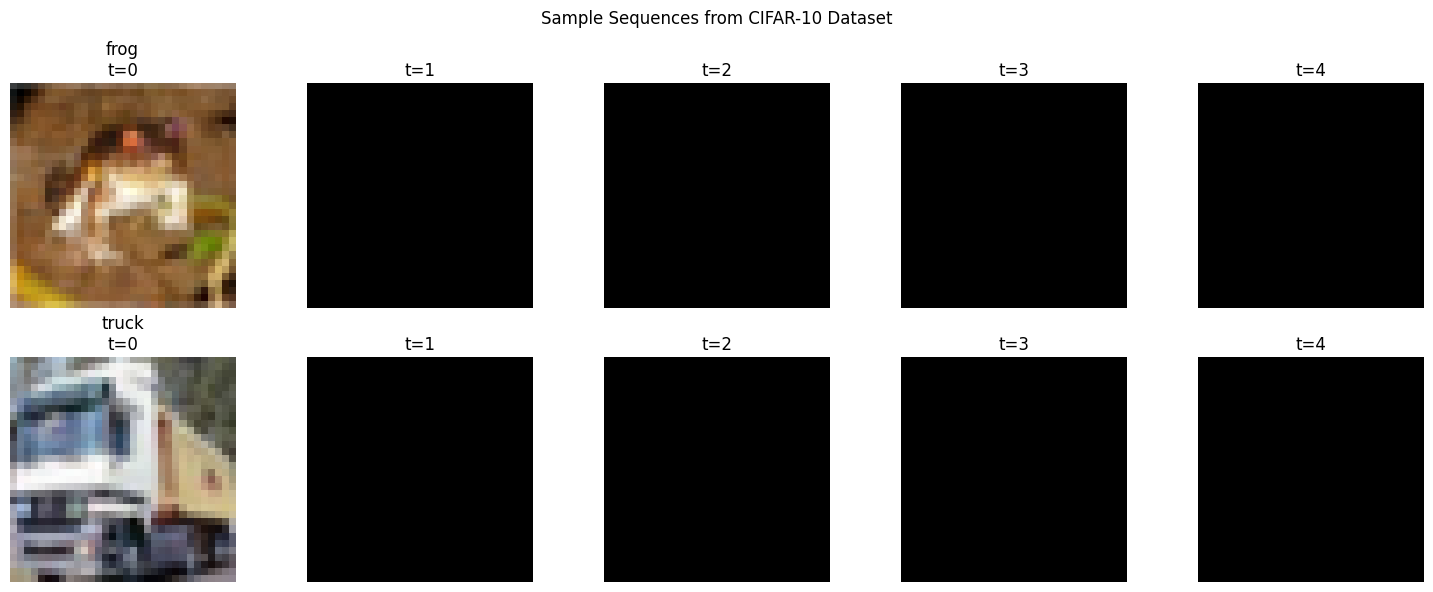

Dataset size: 50000
Sequence shape: torch.Size([5, 3, 32, 32])
Label shape: torch.Size([])
Batch sequences shape: torch.Size([32, 5, 3, 32, 32])
Batch labels shape: torch.Size([32])


In [35]:
class CIFAR10SequenceDataset(Dataset):
    def __init__(self, root, train=True, num_timesteps=5, transform=None):
        self.cifar = datasets.CIFAR10(root=root, train=train, download=True, transform=transform)
        self.num_timesteps = num_timesteps
        self.to_grayscale = transforms.Grayscale(3)  # 3-channel grayscale

    def __len__(self):
        return len(self.cifar)

    def __getitem__(self, idx):
        image, label = self.cifar[idx]
        
        # Create sequence: first frame is the original color image, rest are grayscale
        sequence = [image]
        labels = []
        for _ in range(self.num_timesteps - 1):
            gray_value = torch.rand(1).item()
            gray_frame = torch.full((3, 32, 32), gray_value)
            sequence.append(gray_frame)
        
        sequence = torch.stack(sequence)
        return sequence, label

# Set up parameters
root = './data'
num_timesteps = 5
batch_size = 32

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset and dataloader
dataset = CIFAR10SequenceDataset(root=root, train=True, num_timesteps=num_timesteps, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Plot some samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Sample Sequences from CIFAR-10 Dataset")

for i in range(2):
    sequence, label = dataset[i]
    class_name = dataset.cifar.classes[label]
    
    for t in range(num_timesteps):
        if t == 0:
            # For the first frame, use color
            axes[i, t].imshow(sequence[t].permute(1, 2, 0).numpy() * 0.5 + 0.5)
        else:
            # For subsequent frames, use grayscale
            axes[i, t].imshow(sequence[t][0], cmap='gray')
        axes[i, t].axis('off')
        axes[i, t].set_title(f"{class_name}\nt={t}" if t == 0 else f"t={t}")

plt.tight_layout()
plt.show()

# Print shape information
print(f"Dataset size: {len(dataset)}")
print(f"Sequence shape: {sequence.shape}")
print(f"Label shape: {torch.tensor(label).shape}")

# Get a batch
batch_sequences, batch_labels = next(iter(dataloader))
print(f"Batch sequences shape: {batch_sequences.shape}")
print(f"Batch labels shape: {batch_labels.shape}")